In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import json
import re
from pathlib import Path
from mimas.helper.fileio import NumpyEncoder

import seaborn as sns
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 12
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['svg.fonttype'] = 'none'

path_data = Path().cwd().parent / 'data'

path_figures = Path().cwd().parent / 'figures'
path_figures.mkdir(parents=True, exist_ok=True)

In [2]:
datasource = "mona"

all_df = []
for file_data in (path_data/datasource/"benchmark_result").glob("*.csv"):
    df = pd.read_csv(file_data)
    df['file'] = file_data.stem
    all_df.append(df)

df = pd.concat(all_df)

df["charge"] = df["file"].str.extract(r"charge_(..?)-")
df["library_size"] = df["file"].str.extract(r"against_(.+)$").astype(int)
df


,id,fast_entropy_search,native_entropy_search,max_difference_for_fast_entropy_search,blink,matchms,max_difference_for_blink,query_number,library_number,file,charge,library_size
0,0,0.000133,0.009559,3.467131e-07,0.004735,1.393199,8.498075e-08,100,100,charge_P-100_against_100,P,100
1,1,0.000214,0.009576,2.607218e-07,0.004223,0.002655,4.906983e-09,100,100,charge_P-100_against_100,P,100
2,2,0.000122,0.009582,6.906785e-07,0.003500,0.002642,5.171775e-08,100,100,charge_P-100_against_100,P,100
3,3,0.000143,0.009487,5.132001e-07,0.003458,0.002580,9.762852e-08,100,100,charge_P-100_against_100,P,100
4,4,0.000229,0.009534,6.906785e-07,0.003468,0.002615,3.121065e-08,100,100,charge_P-100_against_100,P,100
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.000759,96.452462,1.705252e-06,0.436505,25.639390,9.566323e-03,100,1000000,charge_N-100_against_1000000,N,1000000
96,96,0.001194,95.409649,1.795706e-06,0.435397,26.235689,1.856665e-01,100,1000000,charge_N-100_against_1000000,N,1000000
97,97,0.002553,96.117770,1.723878e-06,0.438951,27.835478,1.914871e-01,100,1000000,charge_N-100_against_1000000,N,1000000
98,98,0.001213,96.152046,1.373113e-06,0.432636,26.063279,4.885769e-03,100,1000000,charge_N-100_against_1000000,N,1000000


In [3]:
df_error = df[["max_difference_for_fast_entropy_search", "max_difference_for_blink","charge", "library_size"]]

# Rename the columns.
df_error = df_error.rename(columns={"max_difference_for_fast_entropy_search": "fast_entropy_search", "max_difference_for_blink": "blink"})

print(np.max(df_error["fast_entropy_search"].astype(float)))
df_error


2.6826747e-06


,fast_entropy_search,blink,charge,library_size
0,3.467131e-07,8.498075e-08,P,100
1,2.607218e-07,4.906983e-09,P,100
2,6.906785e-07,5.171775e-08,P,100
3,5.132001e-07,9.762852e-08,P,100
4,6.906785e-07,3.121065e-08,P,100
...,...,...,...,...
95,1.705252e-06,9.566323e-03,N,1000000
96,1.795706e-06,1.856665e-01,N,1000000
97,1.723878e-06,1.914871e-01,N,1000000
98,1.373113e-06,4.885769e-03,N,1000000


/tmp/ipykernel_9573/3907984902.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{}".format({"P": "(+) ESI", "N": "(-) ESI"}[x.get_text()]) for x in ax.get_xticklabels()])


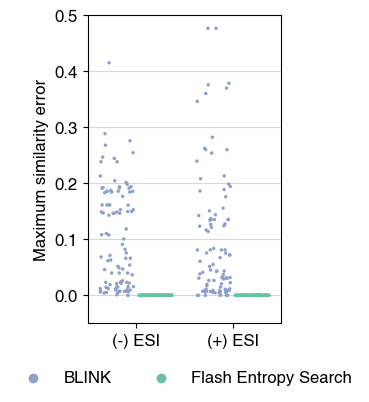

In [4]:
# Plot the figure.
df_plot = df_error.melt(id_vars=["library_size", "charge", ], var_name="method", value_name="max_difference")
df_plot = df_plot[df_plot["library_size"] == 1000000]

#################### Plotting ####################
hue_order = ["blink", "fast_entropy_search"]
order=["N", "P"]
color_palette_set2 = sns.color_palette("Set2", 4)
color_palette = {
    "native_entropy_search": color_palette_set2[1],
    "matchms": color_palette_set2[3],
    "blink": color_palette_set2[2],
    "fast_entropy_search": color_palette_set2[0],
}

fig, ax = plt.subplots(figsize=(2.5, 4))

# Add boxplots with matplotlib
# sns.boxplot(x="charge", y="max_difference", hue="method", data=df_plot, palette=color_palette, hue_order=hue_order,
#             dodge=True, linewidth=0.5, fliersize=0, ax=ax, width=0.6)

sns.stripplot(x="charge", y="max_difference", hue="method", data=df_plot, palette=color_palette, hue_order=hue_order, order=order,
              dodge=True, jitter=0.35, size=2.5, alpha=1, linewidth=0)

# Set the legend outside the plot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-0.05, 0.5)

# Change legend
handles, labels = ax.get_legend_handles_labels()
legend_dict = {l: h for h, l in zip(handles, labels)}
labels_new = ["BLINK", "Flash Entropy Search"]
handles_new = [legend_dict[l] for l in ["blink", "fast_entropy_search"]]
# ax.legend(handles_new, labels_new, frameon=False, loc="upper left", bbox_to_anchor=(1, 0.6))
ax.legend(handles_new, labels_new, frameon=False, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.25))

# Change x-axis labels
# ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])
ax.set_xticklabels(["{}".format({"P": "(+) ESI", "N": "(-) ESI"}[x.get_text()]) for x in ax.get_xticklabels()])

# Set the x-axis label.
ax.set_xlabel("")
ax.set_ylabel("Maximum similarity error")

# Add grid
plt.grid(True, which="both", axis="y", ls="-", alpha=0.5)

plt.savefig(path_figures/f"20_compare_result_accuracy-{datasource}-1m_spectra.svg", bbox_inches="tight", dpi=1200)


/tmp/ipykernel_9573/1588034819.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])


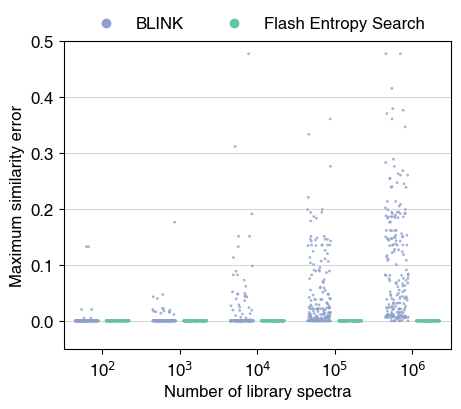

In [5]:
# Plot the figure.
df_plot = df_error.drop(columns=["charge"]).melt(id_vars=["library_size"], var_name="method", value_name="max_difference")

#################### Plotting ####################
fig, ax = plt.subplots(figsize=(5, 4))

# Add boxplots with matplotlib
# sns.boxplot(x="library_size", y="max_difference", hue="method", data=df_plot, palette=color_palette,hue_order=hue_order,
#             dodge=True, linewidth=0.5, fliersize=0)

sns.stripplot(x="library_size", y="max_difference", hue="method", data=df_plot, palette=color_palette,hue_order=hue_order,
              dodge=True, jitter=0.3, size=2, alpha=0.8, linewidth=0)

# Set the legend outside the plot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-0.05, 0.5)

# Change legend
handles, labels = ax.get_legend_handles_labels()
legend_dict = {l: h for h, l in zip(handles, labels)}
labels_new = ["BLINK", "Flash Entropy Search"]
handles_new = [legend_dict[l] for l in [ "blink", "fast_entropy_search"]]
# ax.legend(handles_new, labels_new, frameon=False, loc="upper left", bbox_to_anchor=(1, 0.6))
ax.legend(handles_new, labels_new, frameon=False, loc="upper center",ncol=2, bbox_to_anchor=(0.5, 1.13))

# Change x-axis labels
ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])

# Set the x-axis label.
ax.set_xlabel("Number of library spectra")
ax.set_ylabel("Maximum similarity error")

# Add grid
plt.grid(True, which="both", axis="y", ls="-", alpha=0.5)

plt.savefig(path_figures/f"20_compare_result_accuracy-{datasource}.svg", bbox_inches="tight", dpi=1200)

/tmp/ipykernel_9573/2015552215.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])


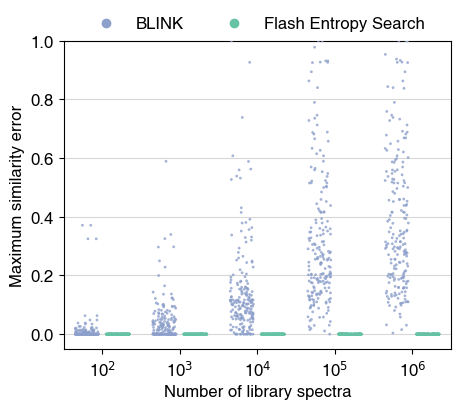

In [6]:
datasource = "gnps"

all_df = []
for file_data in (path_data/datasource/"benchmark_result").glob("*.csv"):
    df = pd.read_csv(file_data)
    df['file'] = file_data.stem
    all_df.append(df)

df = pd.concat(all_df)

df["charge"] = df["file"].str.extract(r"charge_(..?)-")
df["library_size"] = df["file"].str.extract(r"against_(.+)$").astype(int)
df_error = df[["max_difference_for_fast_entropy_search", "max_difference_for_blink", "library_size"]]

# Rename the columns.
df_error = df_error.rename(columns={"max_difference_for_fast_entropy_search": "fast_entropy_search", "max_difference_for_blink": "blink"})

# Plot the figure.
df_plot = df_error.melt(id_vars=["library_size"], var_name="method", value_name="max_difference")

#################### Plotting ####################
fig, ax = plt.subplots(figsize=(5, 4))

# Add boxplots with matplotlib
# sns.boxplot(x="library_size", y="max_difference", hue="method", data=df_plot, palette=color_palette,hue_order=hue_order,
#             dodge=True, linewidth=0.5, fliersize=0)

sns.stripplot(x="library_size", y="max_difference", hue="method", data=df_plot, palette=color_palette,hue_order=hue_order,
              dodge=True, jitter=0.3, size=2, alpha=0.8, linewidth=0)

# Set the legend outside the plot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-0.05, 1)

# Change legend
handles, labels = ax.get_legend_handles_labels()
legend_dict = {l: h for h, l in zip(handles, labels)}
labels_new = ["BLINK", "Flash Entropy Search"]
handles_new = [legend_dict[l] for l in [ "blink", "fast_entropy_search"]]
# ax.legend(handles_new, labels_new, frameon=False, loc="upper left", bbox_to_anchor=(1, 0.6))
ax.legend(handles_new, labels_new, frameon=False, loc="upper center",ncol=2, bbox_to_anchor=(0.5, 1.13))

# Change x-axis labels
ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])

# Set the x-axis label.
ax.set_xlabel("Number of library spectra")
ax.set_ylabel("Maximum similarity error")

# Add grid
plt.grid(True, which="both", axis="y", ls="-", alpha=0.5)

plt.savefig(path_figures/f"20_compare_result_accuracy-{datasource}.svg", bbox_inches="tight", dpi=1200)


/tmp/ipykernel_9573/308946252.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])


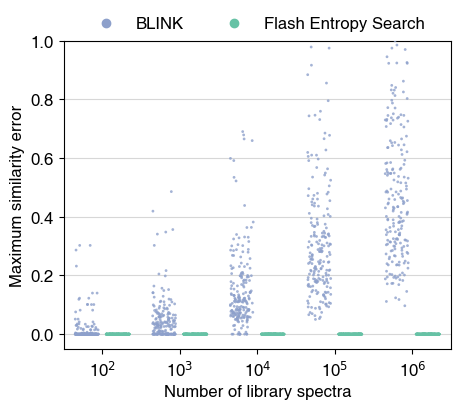

In [7]:
datasource = "public_repository"

all_df = []
for file_data in (path_data/datasource/"benchmark_result").glob("*.csv"):
    df = pd.read_csv(file_data)
    df['file'] = file_data.stem
    all_df.append(df)

df = pd.concat(all_df)

df["charge"] = df["file"].str.extract(r"charge_(..?)-")
df["library_size"] = df["file"].str.extract(r"against_(.+)$").astype(int)
df_error = df[["max_difference_for_fast_entropy_search", "max_difference_for_blink", "library_size"]]

# Rename the columns.
df_error = df_error.rename(columns={"max_difference_for_fast_entropy_search": "fast_entropy_search", "max_difference_for_blink": "blink"})

# Plot the figure.
df_plot = df_error.melt(id_vars=["library_size"], var_name="method", value_name="max_difference")

#################### Plotting ####################
fig, ax = plt.subplots(figsize=(5, 4))

# Add boxplots with matplotlib
# sns.boxplot(x="library_size", y="max_difference", hue="method", data=df_plot, palette=color_palette,hue_order=hue_order,
#             dodge=True, linewidth=0.5, fliersize=0)

sns.stripplot(x="library_size", y="max_difference", hue="method", data=df_plot, palette=color_palette, hue_order=hue_order, 
              dodge=True, jitter=0.3, size=2, alpha=0.8, linewidth=0)

# Set the legend outside the plot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-0.05, 1)

# Change legend
handles, labels = ax.get_legend_handles_labels()
legend_dict = {l: h for h, l in zip(handles, labels)}
labels_new = ["BLINK", "Flash Entropy Search"]
handles_new = [legend_dict[l] for l in ["blink", "fast_entropy_search"]]
# ax.legend(handles_new, labels_new, frameon=False, loc="upper left", bbox_to_anchor=(1, 0.6))
ax.legend(handles_new, labels_new, frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.13))

# Change x-axis labels
ax.set_xticklabels(["10$^{}$".format(int(np.log10(int(x.get_text())))) for x in ax.get_xticklabels()])

# Set the x-axis label.
ax.set_xlabel("Number of library spectra")
ax.set_ylabel("Maximum similarity error")

# Add grid
plt.grid(True, which="both", axis="y", ls="-", alpha=0.5)

plt.savefig(path_figures/f"20_compare_result_accuracy-{datasource}.svg", bbox_inches="tight", dpi=1200)
